In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
import numpy as np
import ta
from os.path import exists
import re
import string
import nltk
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import eco2ai
import difflib
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
# from ptls.preprocessing import PandasDataPreprocessor
# from ptls.data_load.utils import FeatureDict
from sklearn.preprocessing import Normalizer

### Graphs

In [3]:
def create_price_graph(data):
    fig, ax = plt.subplots(figsize=(10,5))

    ax.grid()
    ax.set_title("Daily adjusted close price (Normalized)")
    
    for ticker in data.columns.levels[0]:
        ax.plot(data.index, data[ticker]['Adj Close'] / data[ticker]['Adj Close'][0], label=ticker)

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price ($)')

    ax.legend()

def create_volume_graph(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
    colors = plt.rcParams["axes.prop_cycle"]()

    plt.suptitle("Weekly trading volume")

    for ticker, ax in zip(data.columns.levels[0], axes.ravel()):
        vol = data[ticker].Volume
        ax.bar(vol.index, vol, width=7, color=next(colors)["color"])
        ax.set_title(ticker)

def create_volume_graph(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
    colors = plt.rcParams["axes.prop_cycle"]()

    plt.suptitle("Weekly trading volume")

    for ticker, ax in zip(data.columns.levels[0], axes.ravel()):
        vol = data[ticker].Volume
        ax.bar(vol.index, vol, width=7, color=next(colors)["color"])
        ax.set_title(ticker)

def correlation(data):
    return_df = pd.DataFrame()
    for ticker in data.columns.levels[0]:
        return_df[ticker] = data[ticker].Close.pct_change(1).dropna()
    graph = sns.pairplot(return_df, diag_kind='kde')
    graph.map_lower(sns.kdeplot, levels=5, color=".3")
    print(return_df.corr())
    return return_df

def volatility(data):
    for i, ticker in enumerate(data.columns):
        plt.subplot(7, 1, i+1)
        plt.title(ticker)
        data[ticker].plot(figsize=(12,25))
        plt.grid()
        plt.ylim((-0.2, 0.2))

In [4]:
id_to_ticker_path = "Datasets/kaggle/Company_Tweet.csv"
ticker_to_name_path = "Datasets/kaggle/Company.csv"

tickers_df = pd.read_csv(id_to_ticker_path)
company_name_df = pd.read_csv(ticker_to_name_path)
tickers = company_name_df.ticker_symbol.tolist()

In [8]:
tickers

['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'TSLA', 'MSFT']

In [9]:
market_data = yf.download((' ').join(['AAPL', 'GOOGL', 'AMZN', 'TSLA', 'MSFT']), start="2015-01-01", end="2020-01-01", group_by = 'ticker')

[*********************100%***********************]  5 of 5 completed


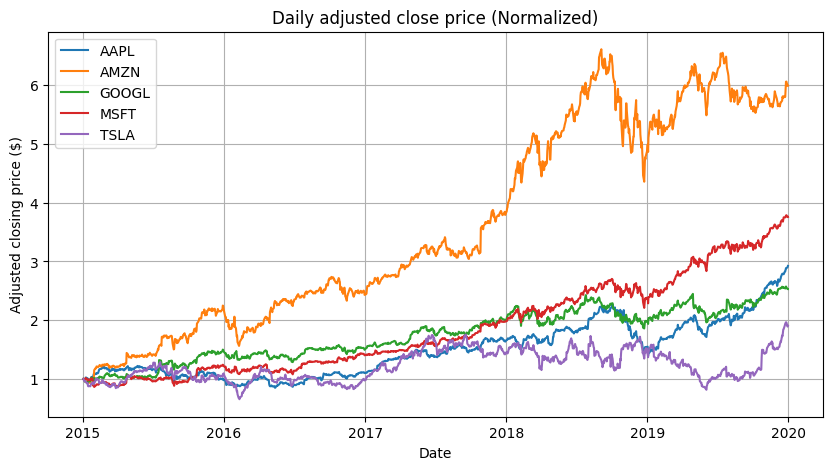

In [10]:
create_price_graph(market_data)

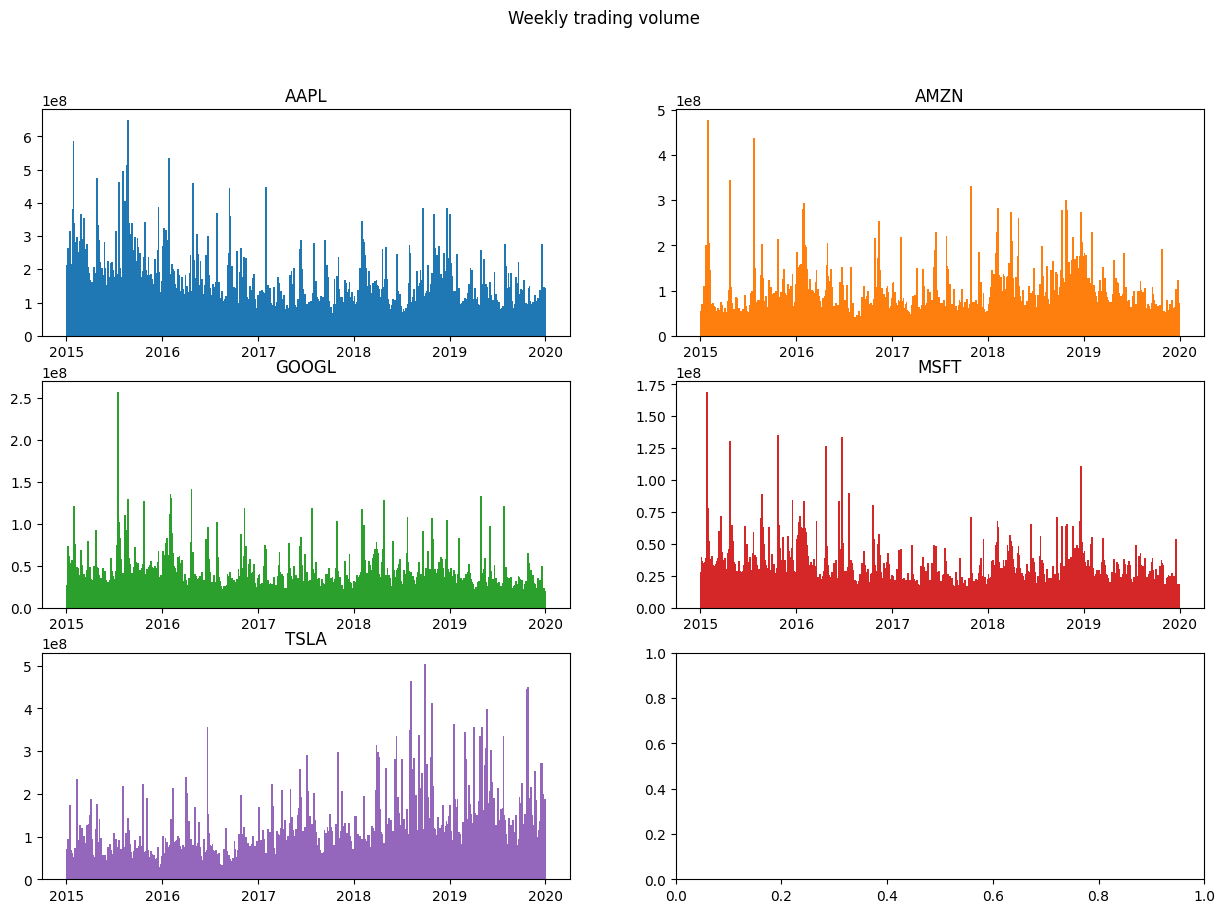

In [11]:
create_volume_graph(market_data)

### Correlation

There is a decent ammout of correlation between each stock except TSLA.

           AAPL      AMZN     GOOGL      MSFT      TSLA
AAPL   1.000000  0.492717  0.520365  0.571620  0.298653
AMZN   0.492717  1.000000  0.641125  0.625687  0.311321
GOOGL  0.520365  0.641125  1.000000  0.651778  0.293364
MSFT   0.571620  0.625687  0.651778  1.000000  0.311203
TSLA   0.298653  0.311321  0.293364  0.311203  1.000000


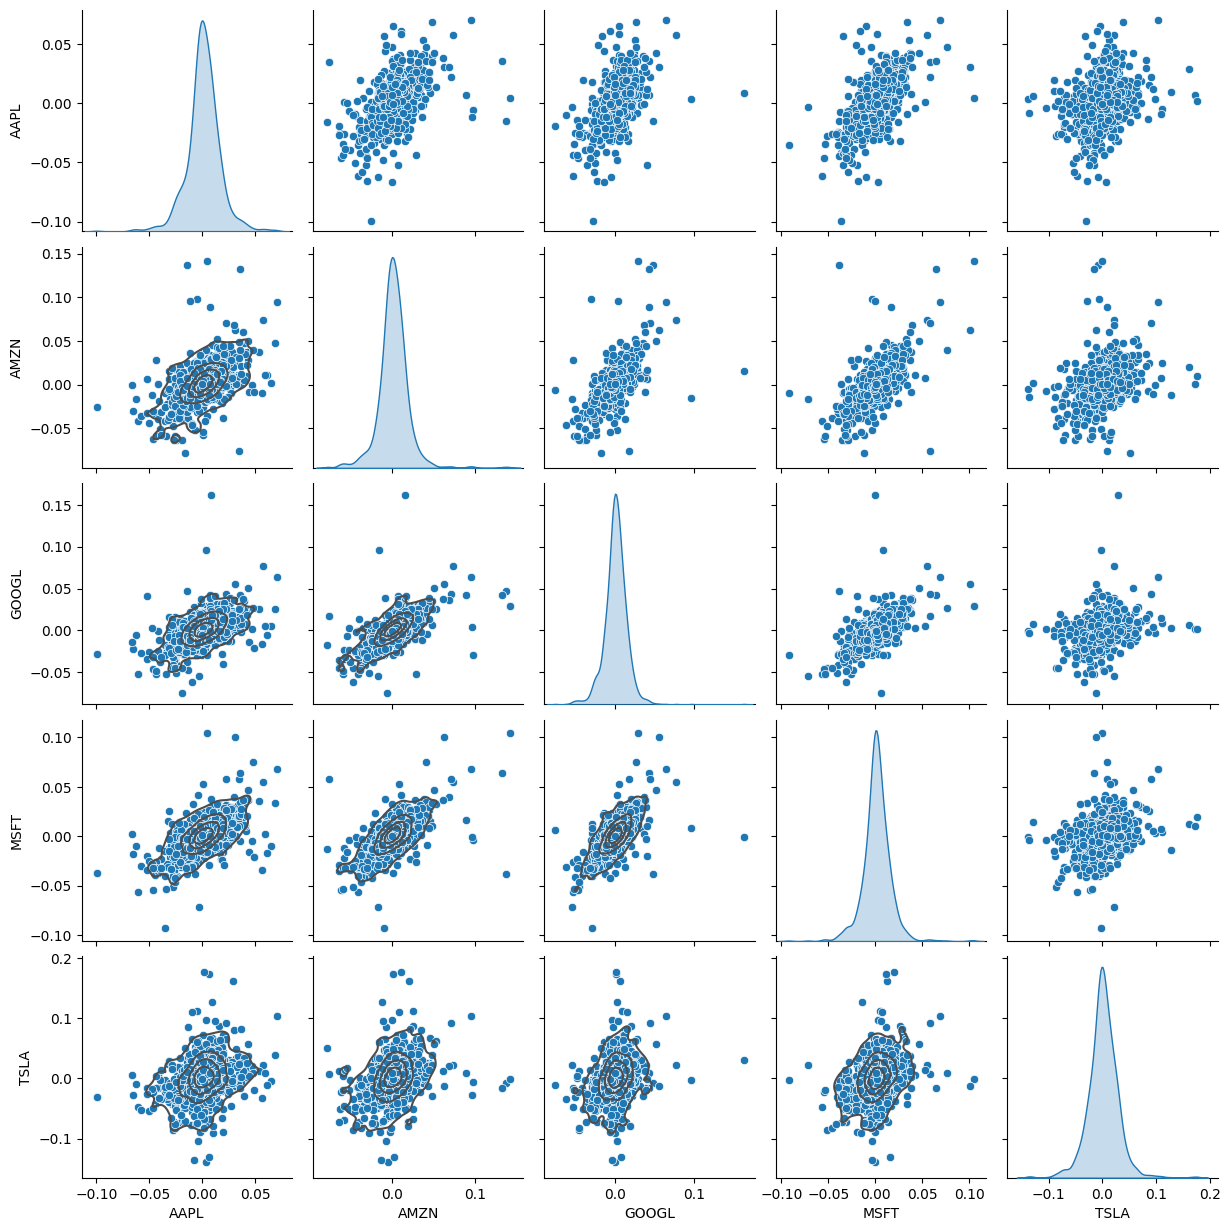

In [14]:
returns = correlation(market_data)

### Volatility

As we can see TSLA is the most volatile stock.

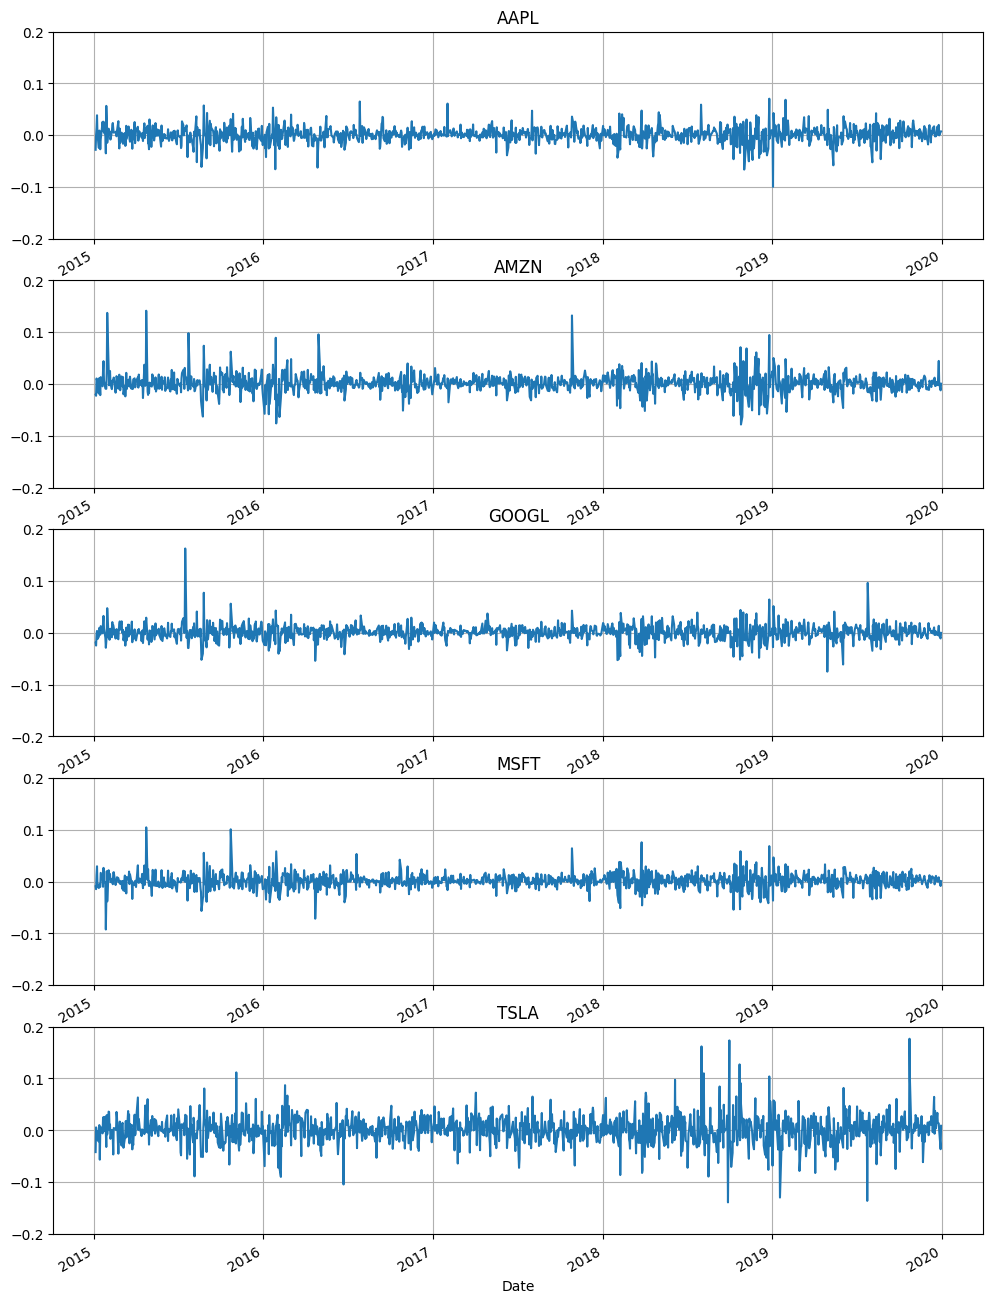

In [15]:
volatility(returns)

## Yahoo Data

In [ ]:
def create_price_graph():
    AAPL = AAPL_stock.Close
    GOOG = GOOG_stock.Close
    GOOGL = GOOGL_stock.Close
    AMZN = AMZN_stock.Close
    TSLA = TSLA_stock.Close

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(10,7))

    ax.grid()
    ax.set_title("Daily close price")

    ax.plot(AAPL.index, AAPL, label='AAPL')
    ax.plot(GOOG.index, GOOG, label='GOOG')
    ax.plot(GOOGL.index, GOOGL, label='GOOGL')
    ax.plot(AMZN.index, AMZN, label='AMZN')
    ax.plot(TSLA.index, TSLA, label='TSLA')

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted closing price ($)')

    ax.legend()

In [ ]:
def create_volume_graph():
    AAPL = AAPL_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    GOOG = GOOG_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    GOOGL = GOOGL_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    AMZN = AMZN_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']
    TSLA = TSLA_stock.groupby(pd.Grouper(freq='W')).sum()['Volume']

    # Plot everything by leveraging the very powerful matplotlib package
    fig, ax = plt.subplots(figsize=(10,7))

    ax.grid()
    ax.set_title("Daily volume")

    ax.bar(AAPL.index, AAPL, label='AAPL', width=5)
    ax.bar(TSLA.index, TSLA, label='TSLA', width=5)
    ax.bar(AMZN.index, AMZN, label='AMZN', width=5)
    ax.bar(GOOGL.index, GOOGL, label='GOOGL', width=5)
    ax.bar(GOOG.index, GOOG, label='GOOG', width=5)

    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')

    ax.legend()

In [ ]:
tickers = company_name_df.ticker_symbol.tolist()
tickers

['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'TSLA', 'MSFT']

### APPL

In [ ]:
# if exists("Datasets/yfinance/AAPL.csv"):
#     AAPL_stock = pd.read_csv("Datasets/yfinance/AAPL.csv", index_col='Date')
# else:
#     AAPL_stock = yf.Ticker(tickers[0]).history(start="2015-01-01", end="2020-01-01")
#     AAPL_stock.index = AAPL_stock.index.normalize()
#     AAPL_stock.to_csv(f"Datasets/yfinance/{tickers[0]}.csv")

# AAPL_stock.index = pd.to_datetime(AAPL_stock.index)
# AAPL_stock.head()

In [ ]:
AAPL_stock = yf.Ticker(tickers[0]).history(start="2015-01-01", end="2020-01-01")
AAPL_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,25.066781,25.078033,24.157634,24.603207,212818400,0.0,0
2015-01-05 00:00:00-05:00,24.369161,24.450175,23.721058,23.910088,257142000,0.0,0
2015-01-06 00:00:00-05:00,23.975356,24.175638,23.545536,23.912346,263188400,0.0,0
2015-01-07 00:00:00-05:00,24.123876,24.348912,24.011358,24.247646,160423600,0.0,0
2015-01-08 00:00:00-05:00,24.580701,25.237806,24.461431,25.179296,237458000,0.0,0


In [ ]:
AAPL_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2015-01-02 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1258 non-null   float64
 1   High          1258 non-null   float64
 2   Low           1258 non-null   float64
 3   Close         1258 non-null   float64
 4   Volume        1258 non-null   int64  
 5   Dividends     1258 non-null   float64
 6   Stock Splits  1258 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 78.6 KB


### GOOG

In [ ]:
# if exists("Datasets/yfinance/GOOG.csv"):
#     GOOG_stock = pd.read_csv("Datasets/yfinance/GOOG.csv", index_col='Date')
# else:
#     GOOG_stock = yf.Ticker(tickers[1]).history(start="2015-01-01", end="2020-01-01")
#     GOOG_stock.index = GOOG_stock.index.normalize()
#     GOOG_stock.to_csv(f"Datasets/yfinance/{tickers[1]}.csv")

# GOOG_stock.head()

In [ ]:
GOOG_stock = yf.Ticker(tickers[1]).history(start="2015-01-01", end="2020-01-01")
GOOG_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,26.378078,26.490770,26.133251,26.168653,28951268,0,0.0
2015-01-05 00:00:00-05:00,26.091366,26.144720,25.582764,25.623152,41196796,0,0.0
2015-01-06 00:00:00-05:00,25.679497,25.738087,24.983908,25.029282,57998800,0,0.0
2015-01-07 00:00:00-05:00,25.280592,25.292759,24.914099,24.986401,41301082,0,0.0
2015-01-08 00:00:00-05:00,24.831326,25.105074,24.482782,25.065184,67071641,0,0.0


In [ ]:
GOOG_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.000000
mean,45.666494,46.054933,45.277309,45.680669,3.413936e+07,0.0,0.000797
std,11.533924,11.639594,11.452816,11.550799,1.697264e+07,0.0,0.028272
min,24.664783,24.730902,24.311253,24.560070,6.950000e+06,0.0,0.000000
25%,36.463751,36.745375,36.125436,36.466002,2.425600e+07,0.0,0.000000
50%,46.486500,46.715250,46.176624,46.473249,2.976300e+07,0.0,0.000000
75%,55.632999,56.213625,55.222587,55.760251,3.898500e+07,0.0,0.000000
max,68.167503,68.250000,67.633499,68.058502,2.232980e+08,0.0,1.002746


### GOOGL

In [ ]:
# if exists("Datasets/yfinance/GOOGL.csv"):
#     GOOGL_stock = pd.read_csv("Datasets/yfinance/GOOGL.csv", index_col='Date')
# else:
#     GOOGL_stock = yf.Ticker(tickers[2]).history(start="2015-01-01", end="2020-01-01")
#     GOOGL_stock.index = GOOGL_stock.index.normalize()
#     GOOGL_stock.to_csv(f"Datasets/yfinance/{tickers[2]}.csv")

# GOOGL_stock.head()

In [ ]:
GOOGL_stock = yf.Ticker(tickers[2]).history(start="2015-01-01", end="2020-01-01")
GOOGL_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,26.629999,26.790001,26.393999,26.477501,26480000,0,0
2015-01-05 00:00:00-05:00,26.357500,26.399500,25.887501,25.973000,41182000,0,0
2015-01-06 00:00:00-05:00,26.025000,26.060499,25.277500,25.332001,54456000,0,0
2015-01-07 00:00:00-05:00,25.547501,25.574499,25.182501,25.257500,46918000,0,0
2015-01-08 00:00:00-05:00,25.075500,25.375000,24.750999,25.345501,73054000,0,0


In [ ]:
GOOGL_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,46.350680,46.741645,45.939285,46.354110,3.726109e+07,0.0,0.0
std,11.287292,11.386466,11.200538,11.298248,1.885330e+07,0.0,0.0
min,24.962000,25.014000,24.545500,24.853001,1.041200e+07,0.0,0.0
25%,37.448502,37.749876,37.078999,37.479752,2.625400e+07,0.0,0.0
50%,47.366251,47.636999,47.002499,47.377249,3.269300e+07,0.0,0.0
75%,55.950376,56.560374,55.556499,56.019501,4.199000e+07,0.0,0.0
max,68.199997,68.352501,67.650002,68.123497,2.571620e+08,0.0,0.0


### AMZN

In [ ]:
# if exists("Datasets/yfinance/AMZN.csv"):
#     AMZN_stock = pd.read_csv("Datasets/yfinance/AMZN.csv", index_col='Date')
# else:
#     AMZN_stock = yf.Ticker(tickers[3]).history(start="2015-01-01", end="2020-01-01")
#     AMZN_stock.index = AMZN_stock.index.normalize()
#     AMZN_stock.to_csv(f"Datasets/yfinance/{tickers[3]}.csv")

AMZN_stock = yf.Ticker(tickers[3]).history(start="2015-01-01", end="2020-01-01")
AMZN_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,15.6290,15.7375,15.3480,15.4260,55664000,0,0
2015-01-05 00:00:00-05:00,15.3505,15.4190,15.0425,15.1095,55484000,0,0
2015-01-06 00:00:00-05:00,15.1120,15.1500,14.6190,14.7645,70380000,0,0
2015-01-07 00:00:00-05:00,14.8750,15.0640,14.7665,14.9210,52806000,0,0
2015-01-08 00:00:00-05:00,15.0160,15.1570,14.8055,15.0230,61768000,0,0


In [ ]:
AMZN_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,55.774627,56.274166,55.177382,55.752367,8.380145e+07,0.0,0.0
std,26.625267,26.851819,26.321770,26.596442,4.501685e+07,0.0,0.0
min,14.314000,14.539500,14.262500,14.347500,1.762600e+07,0.0,0.0
25%,33.284624,33.747499,32.969000,33.239624,5.472550e+07,0.0,0.0
50%,48.577499,48.818001,48.073252,48.394751,7.147900e+07,0.0,0.0
75%,84.037502,84.998751,83.074999,83.847622,9.746950e+07,0.0,0.0
max,101.905502,102.525002,100.650002,101.975502,4.771220e+08,0.0,0.0


### TSLA

In [ ]:
# if exists("Datasets/yfinance/TSLA.csv"):
#     TSLA_stock = pd.read_csv("Datasets/yfinance/TSLA.csv", index_col='Date')
# else:
#     TSLA_stock = yf.Ticker(tickers[4]).history(start="2015-01-01", end="2020-01-01")
#     TSLA_stock.index = TSLA_stock.index.normalize()
#     TSLA_stock.to_csv(f"Datasets/yfinance/{tickers[4]}.csv")

TSLA_stock = yf.Ticker(tickers[4]).history(start="2015-01-01", end="2020-01-01")
TSLA_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,14.858000,14.883333,14.217333,14.620667,71466000,0,0
2015-01-05 00:00:00-05:00,14.303333,14.433333,13.810667,14.006000,80527500,0,0
2015-01-06 00:00:00-05:00,14.004000,14.280000,13.614000,14.085333,93928500,0,0
2015-01-07 00:00:00-05:00,14.223333,14.318667,13.985333,14.063333,44526000,0,0
2015-01-08 00:00:00-05:00,14.187333,14.253333,14.000667,14.041333,51637500,0,0


In [ ]:
TSLA_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.0
mean,17.920343,18.216395,17.613923,17.927925,9.908941e+07,0.0,0.0
std,3.737105,3.794986,3.677695,3.742651,6.235988e+07,0.0,0.0
min,9.488000,10.331333,9.403333,9.578000,1.062000e+07,0.0,0.0
25%,14.797833,15.008333,14.535500,14.724167,5.993175e+07,0.0,0.0
50%,17.174334,17.480000,16.888333,17.185000,8.286375e+07,0.0,0.0
75%,21.078167,21.465167,20.719667,21.111834,1.175944e+08,0.0,0.0
max,29.000000,29.020666,28.423332,28.729334,5.047455e+08,0.0,0.0


In [ ]:
# if exists("Datasets/yfinance/MSFT.csv"):
#     MSFT_stock = pd.read_csv("Datasets/yfinance/MSFT.csv", index_col='Date')
# else:
#     MSFT_stock = yf.Ticker(tickers[5]).history(start="2015-01-01", end="2020-01-01")
#     MSFT_stock.index = MSFT_stock.index.normalize()
#     MSFT_stock.to_csv(f"Datasets/yfinance/{tickers[5]}.csv")

MSFT_stock = yf.Ticker(tickers[5]).history(start="2015-01-01", end="2020-01-01")
MSFT_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,40.724151,41.387466,40.619418,40.811428,27913900,0.0,0
2015-01-05 00:00:00-05:00,40.471043,40.785246,40.366310,40.436134,39673900,0.0,0
2015-01-06 00:00:00-05:00,40.479769,40.802698,39.746629,39.842636,36447900,0.0,0
2015-01-07 00:00:00-05:00,40.130673,40.549610,39.703010,40.348869,29114100,0.0,0
2015-01-08 00:00:00-05:00,40.802707,41.675492,40.776525,41.535847,29645200,0.0,0


In [ ]:
MSFT_stock.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.0
mean,76.118384,76.723762,75.451167,76.130480,2.912099e+07,0.006328,0.0
std,32.300696,32.499515,32.008074,32.276086,1.396202e+07,0.050272,0.0
min,35.426348,35.810310,35.112145,35.260513,7.425600e+06,0.000000,0.0
25%,47.919201,48.401343,47.612143,48.149858,2.068352e+07,0.000000,0.0
50%,66.049247,66.636446,65.517982,66.184410,2.594710e+07,0.000000,0.0
75%,101.679146,102.747008,100.512766,101.643225,3.333992e+07,0.000000,0.0
max,155.014492,155.111716,153.818711,154.538132,1.691640e+08,0.510000,0.0


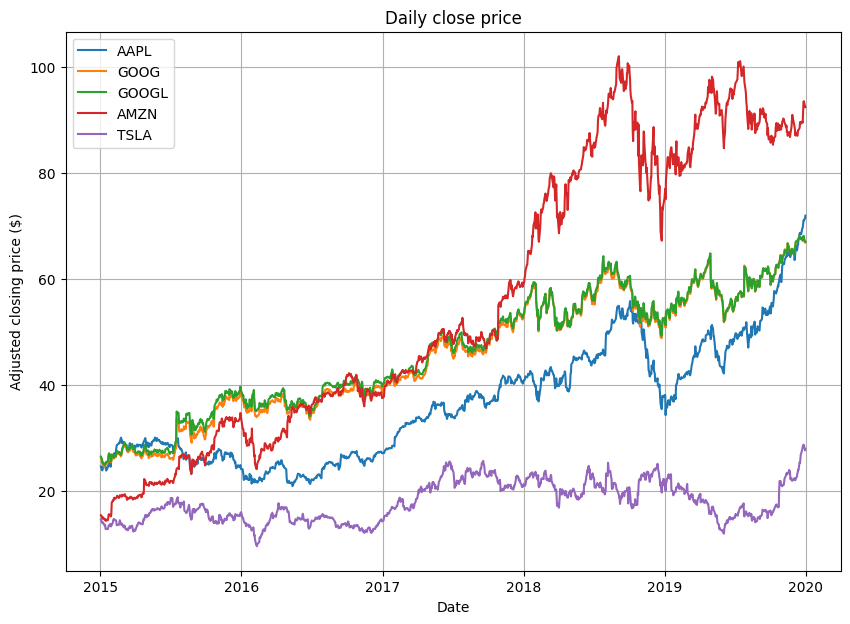

In [ ]:
create_price_graph()

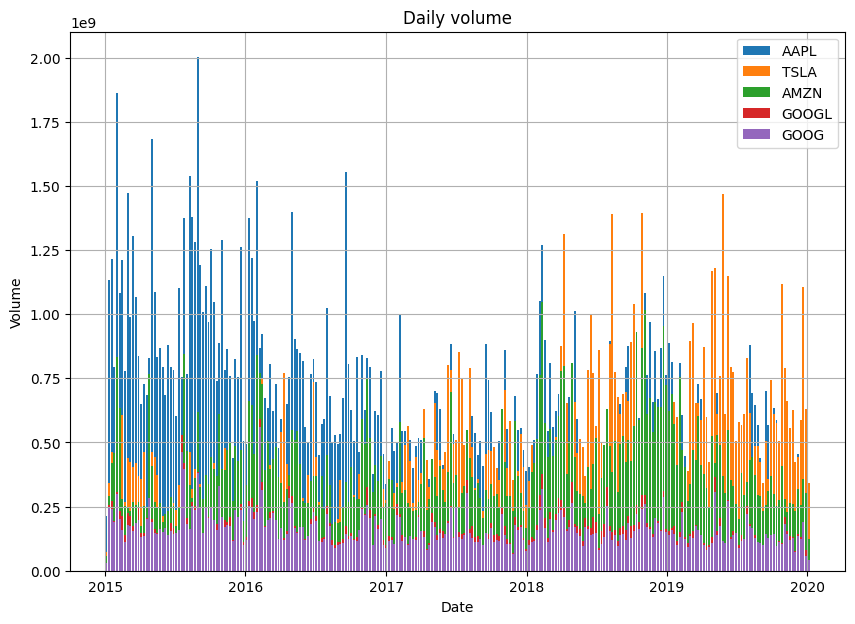

In [ ]:
create_volume_graph()

## Combined

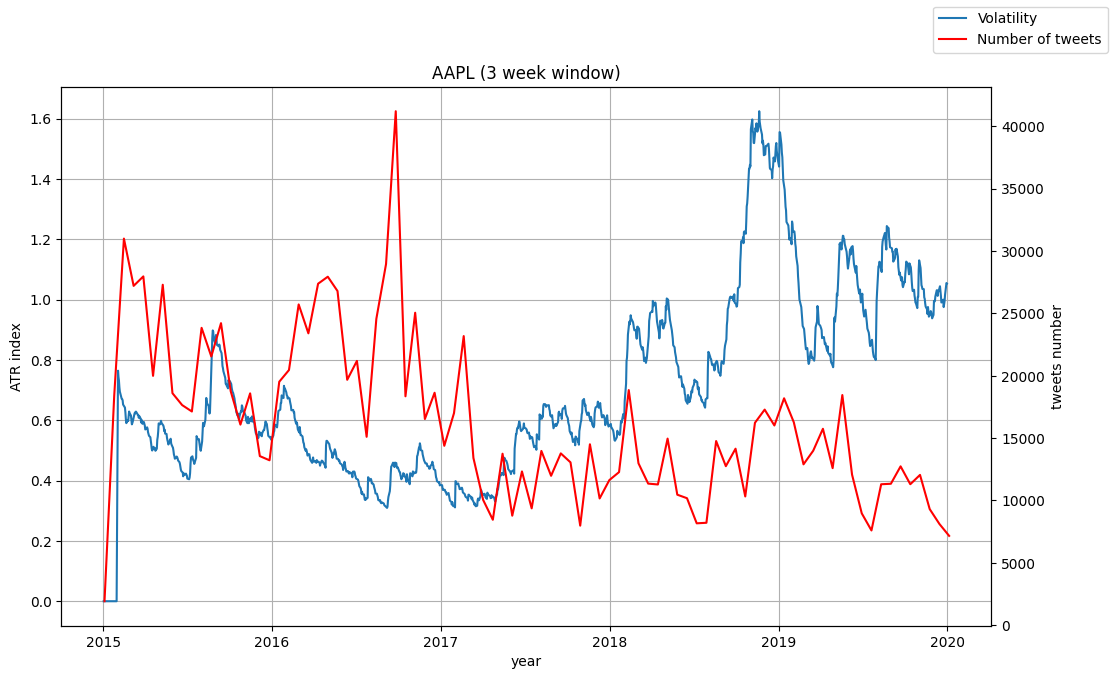

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=AAPL_stock.High, low=AAPL_stock.Low, close=AAPL_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('AAPL (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'AAPL'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
ax.grid()
fig.legend()
plt.show();

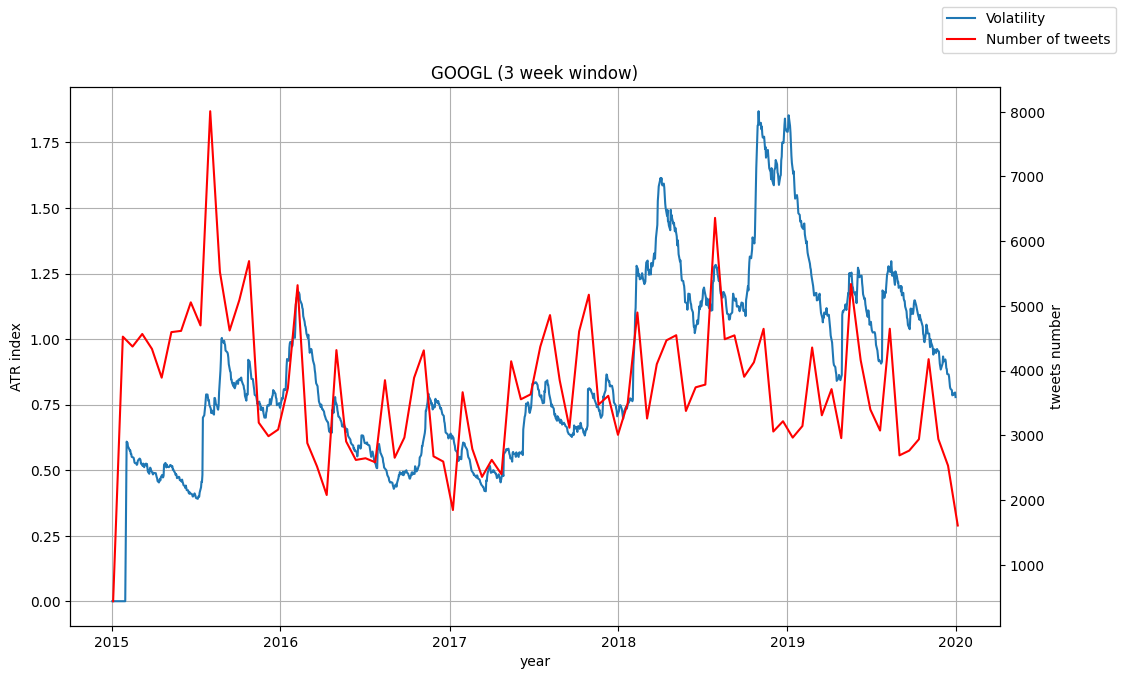

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=GOOGL_stock.High, low=GOOGL_stock.Low, close=GOOGL_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('GOOGL (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'GOOGL'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
ax.grid()
fig.legend()
plt.show();

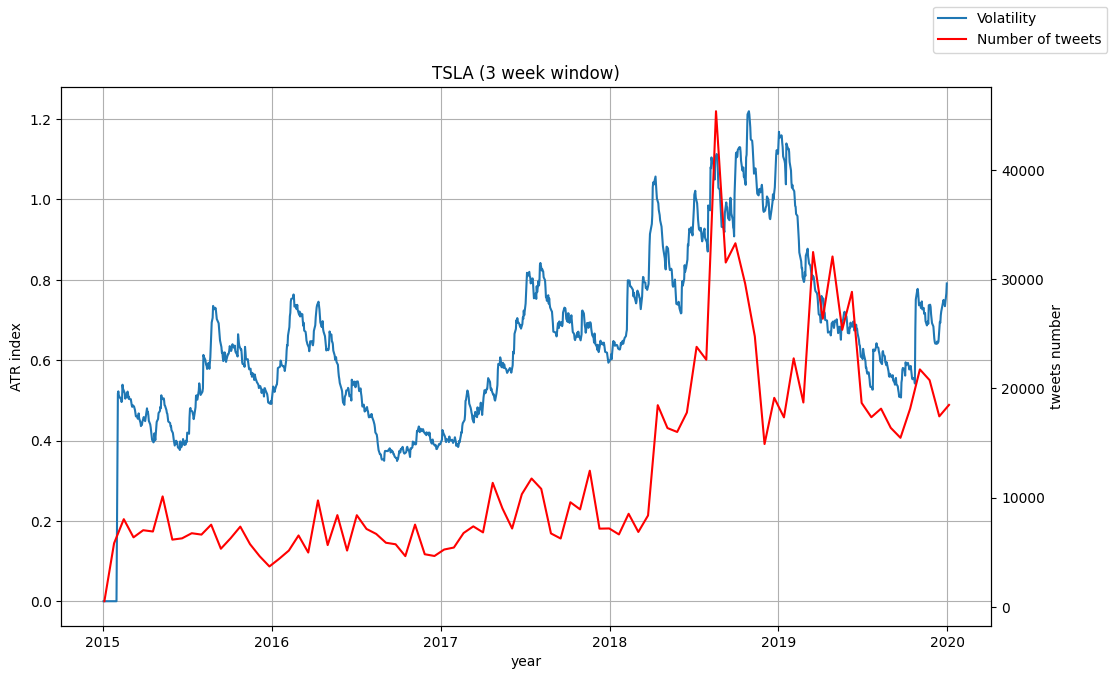

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=TSLA_stock.High, low=TSLA_stock.Low, close=TSLA_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('TSLA (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'TSLA'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')

ax.grid()
fig.legend()
plt.show();

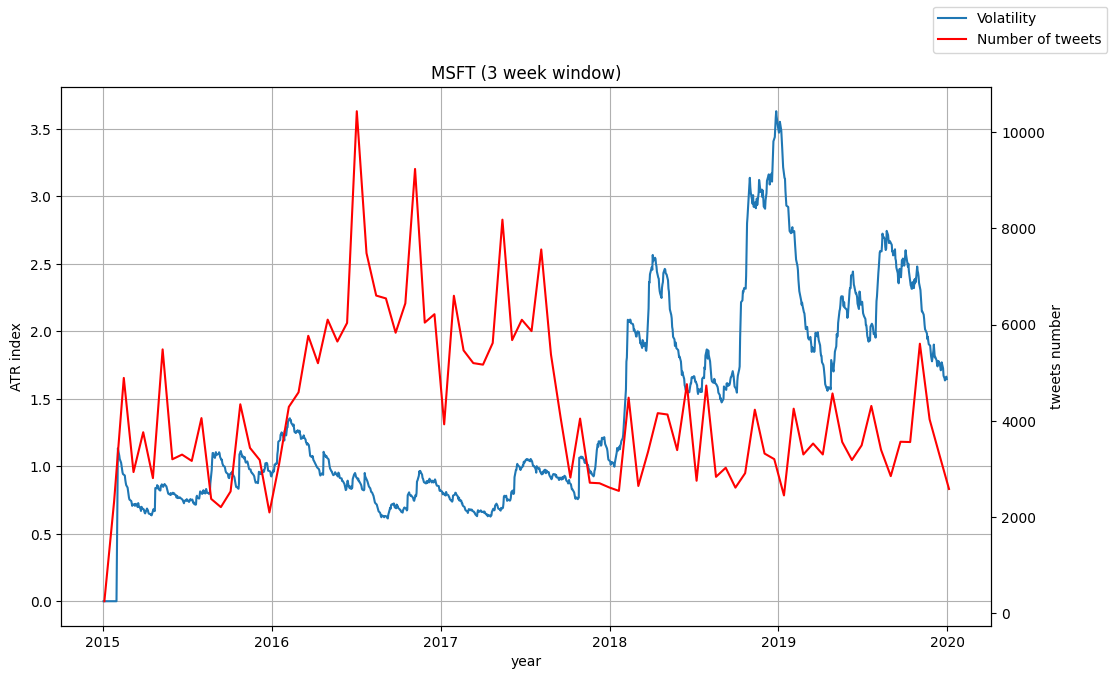

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=MSFT_stock.High, low=MSFT_stock.Low, close=MSFT_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('MSFT (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'MSFT'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
ax.grid()
fig.legend()
plt.show();

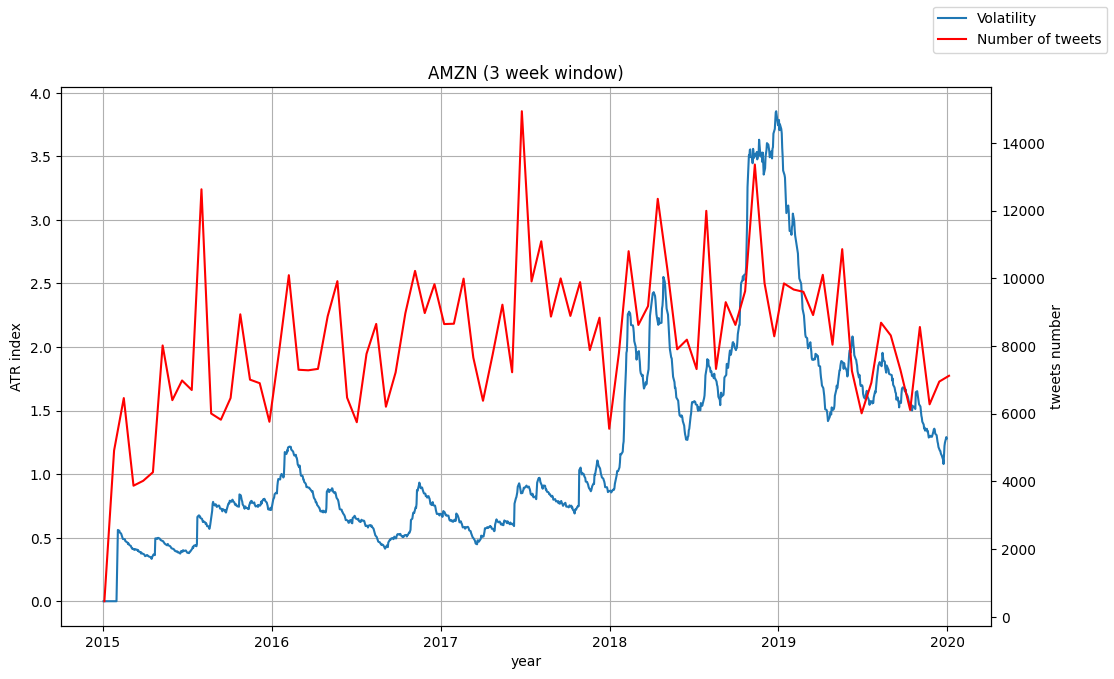

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(ta.volatility.AverageTrueRange(
    high=AMZN_stock.High, low=AMZN_stock.Low, close=AMZN_stock.Close, window=21).average_true_range(), label='Volatility')
ax.set_title('AMZN (3 week window)')
ax.set_xlabel('year')
ax.set_ylabel('ATR index')
ax2 = ax.twinx()
ax2.plot(merged_df[merged_df.ticker_symbol == 'AMZN'].groupby(pd.Grouper(
    key='post_date', axis=0, freq='3w')).count()['tweet_id'], color='r', label='Number of tweets')
ax2.set_ylabel('tweets number')
ax.grid()
fig.legend()
plt.show();